In [1]:
import overpass
from IPython.display import display
import geopandas as gpd

def get_point_data(node_name: str, area_name: str, api: overpass.API, date: str = None):
    query = ""
    # if date is not None: # to jeszcze nie dziala :(
    #     query += f'[date:"{date}"];'
    # else:
    #     query += ''
    query += f'''
    area["name"="{area_name}"]->.a;
    (
        node["{node_name}"](area.a);
    );
    out center;
    '''
    resp = api.get(query)
    nodes = []
    for node in resp['features']:
        x, y = node["geometry"]["coordinates"]
        node_geom = gpd.points_from_xy([x], [y])[0]
        name = node["properties"][node_name]
        nodes.append({"geometry": node_geom, "type": name})
    return nodes

api = overpass.API()
node_names = ['amenity', 'building', 'highway', 'public_transport', 'government', 'leisure', 'office', 'natural']
area_name = 'Virginia Beach'
date = '2019-01-01T00:00:00Z'
amenities = get_point_data(node_names[0], area_name, api)
buildings = get_point_data(node_names[1], area_name, api)
highways = get_point_data(node_names[2], area_name, api)
public_transport = get_point_data(node_names[3], area_name, api)
government = get_point_data(node_names[4], area_name, api)
leisure = get_point_data(node_names[5], area_name, api)
office = get_point_data(node_names[6], area_name, api)
natural = get_point_data(node_names[7], area_name, api)

In [2]:

# combine features into one category
# leisure = [{'geometry': item['geometry'], 'type': 'leisure'} for item in leisure]
building_categories = {
    'accomodation': {'apartments', 'barracks', 'bungalow', 'cabin', 'detached', 'dormitory', 'farm', 'ger', 'hotel', 'house', 'houseboat', 'residential', 'semidetached_house', 'static_caravan', 'stilt_house', 'terrace', 'tree_house', 'trullo'},
    'commercial': {'commercial', 'industrial', 'kiosk', 'office', 'retail', 'supermarket', 'warehouse'},
    'religious': {'cathedral', 'chapel', 'church', 'kingdom_hall', 'monastery', 'mosque', 'presbytery', 'religious', 'shrine', 'synagogue', 'temple'},
    'civic': {'bakehouse', 'bridge', 'civic', 'college', 'fire_station', 'government', 'gatehouse', 'hospital', 'kindergarten', 'museum', 'public', 'school', 'toilets', 'train_station', 'transportation', 'university'},
    'agricultural': {'barn', 'conservatory', 'cowshed', 'farm_auxiliary', 'greenhouse', 'slurry_tank', 'stable', 'sty', 'livestock'},
    'sports': {'grandstand', 'pavilion', 'riding_hall', 'sports_hall', 'sports_centre', 'stadium'},
    'storage': {'allotment_house', 'boathouse', 'hangar', 'hut', 'shed'},
    'cars': {'carport', 'garage', 'garages', 'parking'},
    'power': {'digester', 'service', 'tech_cab', 'transformer_tower', 'water_tower', 'storage_tank', 'silo'},
    'other': {'beach_hut', 'bunker', 'castle', 'construction', 'container', 'guardhouse', 'military', 'outbuilding', 'pagoda', 'quonset_hut', 'roof', 'ruins', 'tent', 'tower', 'windmill'}
}

ammenity_categories = {
    'sustenance': {'bar', 'biergarten', 'cafe', 'fast_food', 'food_court', 'ice_cream', 'pub', 'restaurant'},
    'education': {'college', 'dancing_school', 'driving_school', 'first_aid_school', 'kindergarten', 'language_school', 'library', 'surf_school', 'toy_library', 'research_institute', 'training', 'music_school', 'school', 'traffic_park', 'university'},
    'transportation': {'bicycle_parking', 'bicycle_repair_station', 'bicycle_rental', 'bicycle_wash', 'boat_rental', 'boat_sharing', 'bus_station', 'car_rental', 'car_sharing', 'car_wash', 'compressed_air', 'vehicle_inspection', 'charging_station', 'driver_training', 'ferry_terminal', 'fuel', 'grit_bin', 'motorcycle_parking', 'parking', 'parking_entrance', 'parking_space', 'taxi', 'weighbridge'},
    'financial': {'atm', 'payment_terminal', 'bank', 'bureau_de_change'},
    'healthcare': {'baby_hatch', 'clinic', 'dentist', 'doctors', 'hospital', 'nursing_home', 'pharmacy', 'social_facility', 'veterinary'},
    'entertainment': {'arts_centre', 'brothel', 'casino', 'cinema', 'community_centre', 'conference_centre', 'events_venue', 'exhibition_centre', 'fountain', 'gambling', 'love_hotel', 'music_venue', 'nightclub', 'planetarium', 'public_bookcase', 'social_centre', 'stripclub', 'studio', 'swingerclub', 'theatre'},
    'public_service': {'courthouse', 'fire_station', 'police', 'post_box', 'post_depot', 'post_office', 'prison', 'ranger_station', 'townhall'},
    'facilities': {'bbq', 'bench', 'dog_toilet', 'dressing_room', 'drinking_water', 'give_box', 'mailroom', 'parcel_locker', 'shelter', 'shower', 'telephone', 'toilets', 'water_point', 'watering_place'},
    'waste_management': {'sanitary_dump_station', 'recycling', 'waste_basket', 'waste_disposal', 'waste_transfer_station'},
}

def reverse_dict(d):
    new_d = {}
    for category in d:
        for amenity_type in d[category]:
            new_d[amenity_type] = category
    return new_d

building_dict = reverse_dict(building_categories)
amenity_dict = reverse_dict(ammenity_categories)

def change_types(type_dict: dict, data: list, default='other'):
    for data_dict in data:
        if data_dict['type'] in type_dict:
            data_dict['type'] = type_dict[data_dict['type']]
        else:
            data_dict['type'] = default

# change_types(building_dict, buildings, 'other_building')
# change_types(amenity_dict, amenities, 'other_amenity')

# create gdf from amenities
# update amenities with changed building types
amenities.extend(highways)
# update amenities with raw category types
amenities.extend(leisure)
amenities.extend(office)
amenities.extend(government)
amenities.extend(public_transport)
amenities.extend(natural)
features_gdf = gpd.GeoDataFrame(data=[{'name': amen['type']} for amen in amenities], geometry=[amen['geometry'] for amen in amenities], crs='EPSG:4326')
print(features_gdf.head())

               name                    geometry
0  place_of_worship  POINT (-76.04799 36.70960)
1        grave_yard  POINT (-76.01854 36.59043)
2  place_of_worship  POINT (-76.08286 36.58601)
3  place_of_worship  POINT (-76.07354 36.55765)
4            school  POINT (-76.02160 36.59710)


In [3]:
# import data from VBOHCAR.xlsx to a pandas dataframe
import io
import pandas as pd
import requests
from os import listdir

# check for the vbohcar.xlsx file in the current directory
if 'VBOHCAR.xlsx' in listdir():
        # read the third sheet of the excel file
    df = pd.read_excel('VBOHCAR.xlsx', sheet_name=3)
else:
    # clone the excel file from github
    url = 'https://github.com/INFORMSJoC/2020.1022/blob/master/results/VBOHCAR.xlsx?raw=true'
    file = requests.get(url)
    file_bytes = io.BytesIO(file.content)
    # read the third sheet of the excel file
    df = pd.read_excel(file_bytes, sheet_name=3)

# convert the pandas dataframe to a geopandas dataframe and add a geometry column with crs set
ohca_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Longitude'], df['Latitude']), crs='EPSG:4326')

# delete unused columns
columns_to_drop = ['Incident_Location', 'MinimumResponseTime', 'ReceivedTime', 'ID_OHCA', 'X_OHCA', 'Y_OHCA', 'Z_OHCA']
for column in columns_to_drop:
    if column in ohca_gdf.columns:
        del ohca_gdf[column]

print(ohca_gdf.head())

    Latitude  Longitude                    geometry
0  36.862471 -76.024169  POINT (-76.02417 36.86247)
1  36.766897 -76.042337  POINT (-76.04234 36.76690)
2  36.766897 -76.042337  POINT (-76.04234 36.76690)
3  36.905880 -76.118769  POINT (-76.11877 36.90588)
4  36.620850 -76.090090  POINT (-76.09009 36.62085)


In [4]:
import h3

# create a dict hexagon_amenities = {hexagon_id: {amenity_name: count}}
hexagon_amenities = {}
for amen_dict in features_gdf.iterrows():
    amenity = amen_dict[1]['name']
    hexagon = h3.geo_to_h3(amen_dict[1]['geometry'].y, amen_dict[1]['geometry'].x, 9)
    if hexagon in hexagon_amenities:
        hexagon_amenities[hexagon][amenity] += 1
    else:
        hexagon_amenities[hexagon] = {}
        for amenity in features_gdf['name'].unique():
            hexagon_amenities[hexagon][amenity] = 0
        hexagon_amenities[hexagon][amenity] += 1

# convert to a dataframe
# amenity_name, amenity_name2, amenity_name3, ...
# count, count2, count3, ...
hexagon_amenities_df = pd.DataFrame(hexagon_amenities).T

# count ohca in each hexagon
hexagon_ohca = {}
for ohca in ohca_gdf.iterrows():
    hexagon = h3.geo_to_h3(ohca[1]['geometry'].y, ohca[1]['geometry'].x, 9)
    if hexagon in hexagon_ohca:
        hexagon_ohca[hexagon] += 1
    else:
        hexagon_ohca[hexagon] = 1

# add ohca count to the hexagon_amenities_df
hexagon_amenities_df['ohca_count'] = [hexagon_ohca[h] if h in hexagon_ohca else 0 for h in hexagon_amenities_df.index]
display(hexagon_amenities_df.head())

,place_of_worship,grave_yard,school,post_office,childcare,university,courthouse,fire_station,library,police,...,environment,stop_position,platform,peak,bay,beach,water,tree,cape,ohca_count
892af0c9adbffff,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
892af052a6bffff,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
892af051c37ffff,1,2,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,1,1
892af0519b3ffff,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
892af0501b3ffff,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [5]:
# create a map, color hexagons by the predicted number of ohca
import folium

# create a map
m = folium.Map(location=[36.8529, -75.9780], zoom_start=11)

# add hexagons with opacity based on the number of ohca
for hexagon in hexagon_amenities_df.index:
    # get ohca from the hexagon_amenities_df
    ohca = hexagon_amenities_df.loc[hexagon, 'ohca_count']
    opacity = ohca / 10
    color = 'red'
    locs = [(pos[0], pos[1]) for pos in h3.h3_to_geo_boundary(hexagon)]
    # create a polygon from the hexagon
    folium.Polygon(locations=locs, color=color, fill_color=color, fill_opacity=opacity).add_to(m)

m

In [6]:
import numpy as np

unique_features = features_gdf['name'].unique()

# Create new columns for each unique feature
for amenity in unique_features:
    new_columns = pd.DataFrame({f"{amenity}_neighbour_count": 0}, index=hexagon_amenities_df.index)
    hexagon_amenities_df = pd.concat([hexagon_amenities_df, new_columns], axis=1)

# Iterate through hexagon_amenities_df index
for h in hexagon_amenities_df.index:
    neighbours = np.array(list(h3.k_ring(h, 1)))  # Convert set to array
    common_indices = np.intersect1d(neighbours, hexagon_amenities_df.index)
    
    # Increment the counts using vectorized operations
    hexagon_amenities_df.loc[h, unique_features + '_neighbour_count'] += hexagon_amenities_df.loc[common_indices, unique_features].values.sum(axis=0)

# Ensure integer type for the new columns
hexagon_amenities_df[unique_features + '_neighbour_count'] = hexagon_amenities_df[unique_features + '_neighbour_count'].astype(int)


# delete rows with 0s in all columns
# print how many rows were deleted
hexagon_amenities_df = hexagon_amenities_df[(hexagon_amenities_df.T != 0).any()]
display(hexagon_amenities_df.head())


,place_of_worship,grave_yard,school,post_office,childcare,university,courthouse,fire_station,library,police,...,administrative_neighbour_count,environment_neighbour_count,stop_position_neighbour_count,platform_neighbour_count,peak_neighbour_count,bay_neighbour_count,beach_neighbour_count,water_neighbour_count,tree_neighbour_count,cape_neighbour_count
892af0c9adbffff,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
892af052a6bffff,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
892af051c37ffff,1,2,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,3
892af0519b3ffff,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
892af0501b3ffff,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [7]:
# use elastic net to predict ohca count
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error


data_len = len(hexagon_amenities_df)
n = 5
mean_rme = 0
mean_avg_err = 0
for i in range(n):
    # shuffle data
    hexagon_amenities_df = hexagon_amenities_df.sample(frac=1).reset_index(drop=True)

    # split data into X and y
    X = hexagon_amenities_df.drop(columns=['ohca_count'])
    y = hexagon_amenities_df['ohca_count']

    # split data into train and test sets
    start = int(data_len / n * i)
    end = int(data_len / n * (i + 1))
    X_test = X[start:end]
    y_test = y[start:end]
    X_train = X.drop(X.index[start:end])
    y_train = y.drop(y.index[start:end])
    # fit model no training data
    model = ElasticNet()
    model.fit(X_train, y_train)

    # make predictions for test data
    y_pred = model.predict(X_test)
    y_pred = np.clip(y_pred, 0, np.inf)
    avg_ohca = np.mean(y_train)
    avg_pred = np.full(len(y_pred), avg_ohca)
    mean_error = mean_squared_error(y_test, y_pred, squared=False)
    mean_rme += mean_error
    avg_err = mean_squared_error(y_test, avg_pred, squared=False)
    mean_avg_err += avg_err
    print(f"Mean error: \t\t\t{mean_error:.3f}")
    avg_pred_err = mean_squared_error(y_test, avg_pred, squared=False)
    print(f"Error for predicting average: \t{avg_pred_err:.3f}")

print(f"Mean mean error: {(mean_rme / n):.3f}")
print(f"Mean error for predicting average: {(mean_avg_err / n):.3f}")
if mean_rme < mean_avg_err :
    print(f"ElasticNet is better than predicting average by {((mean_avg_err - mean_rme)/n):.3f}!!")
else:
    print(f"ElasticNet is worse than predicting average by {((mean_rme - mean_avg_err)/n):.3f} :(")


Mean error: 			2.466
Error for predicting average: 	2.519
Mean error: 			1.587
Error for predicting average: 	1.658
Mean error: 			2.056
Error for predicting average: 	2.078
Mean error: 			1.870
Error for predicting average: 	1.942
Mean error: 			3.069
Error for predicting average: 	3.109
Mean mean error: 2.210
Mean error for predicting average: 2.261
ElasticNet is better than predicting average by 0.051!!


In [8]:
# other model comparison
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LassoLars
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.linear_model import TheilSenRegressor
from sklearn.model_selection import train_test_split

models = [
    XGBRegressor(objective='reg:squarederror'),
    LinearRegression(),
    Ridge(),
    Lasso(),
    BayesianRidge(),
    ElasticNet(),
    LassoLars(),
    OrthogonalMatchingPursuit(),
    # TheilSenRegressor(),
    GradientBoostingRegressor(),
]
# shuffle data
hexagon_amenities_df = hexagon_amenities_df.sample(frac=1).reset_index(drop=True)
X = hexagon_amenities_df.drop(columns=['ohca_count'])
y = hexagon_amenities_df['ohca_count']

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
min_model = models[0]
min_error = np.inf
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred = np.clip(y_pred, 0, np.inf)
    mean_error = mean_squared_error(y_test, y_pred, squared=False)
    print(f"Model: {model.__class__.__name__} Mean error: {mean_error:.4f}")
    if mean_error < min_error:
        min_error = mean_error
        min_model = model

print(f"Min error: {min_error:.4f}")
print(f"Min model: {min_model}")

Model: XGBRegressor Mean error: 2.8243
Model: LinearRegression Mean error: 198983381.1074
Model: Ridge Mean error: 2.9414
Model: Lasso Mean error: 2.9131
Model: BayesianRidge Mean error: 2.8486
Model: ElasticNet Mean error: 2.9050
Model: LassoLars Mean error: 2.9131
Model: OrthogonalMatchingPursuit Mean error: 2.8565
Model: GradientBoostingRegressor Mean error: 2.8229
Min error: 2.8229
Min model: GradientBoostingRegressor()


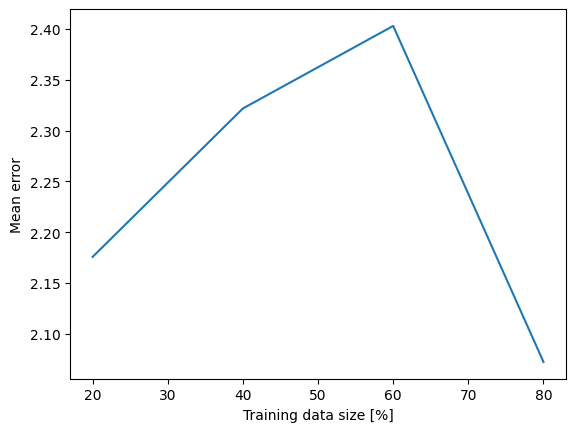

In [14]:
# learning progress
# this just shows that the more data we have, the better the model is
# there is not enough data to train the model
errs = []

# shuffle data
hexagon_amenities_df = hexagon_amenities_df.sample(frac=1).reset_index(drop=True)
for i in range(n - 1):
    # split data into X and y
    X = hexagon_amenities_df.drop(columns=['ohca_count'])
    y = hexagon_amenities_df['ohca_count']

    # split data into train and test sets
    start = 0
    end = int(data_len / n * (i + 1))
    X_train = X[start:end]
    y_train = y[start:end]
    X_test = X.drop(X.index[start:end])
    y_test = y.drop(y.index[start:end])
    # fit model no training data
    model = ElasticNet()
    model.fit(X_train, y_train)

    # make predictions for test data
    y_pred = model.predict(X_test)
    y_pred = np.clip(y_pred, 0, np.inf)
    mean_error = mean_squared_error(y_test, y_pred, squared=False)
    errs.append(mean_error)

xs = [(i + 1) * 100 / n for i in range(n - 1)]
ys = errs
import matplotlib.pyplot as plt
plt.plot(xs, ys)
plt.xlabel('Training data size [%]')
plt.ylabel('Mean error')
plt.show()

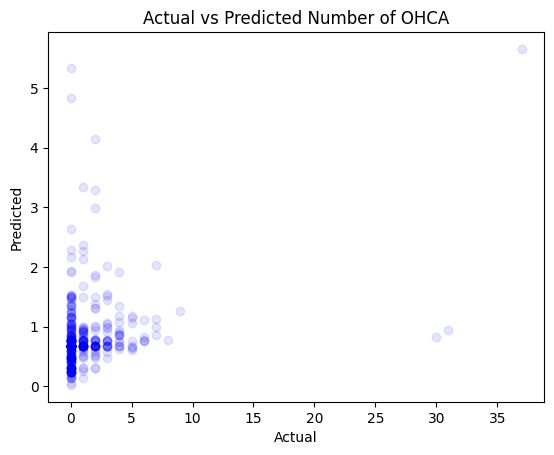

In [9]:
# show predictions vs actual
import matplotlib.pyplot as plt
# color based on density of points on the graph
plt.scatter(y_test, y_pred, c='b', alpha=0.1)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Number of OHCA')
plt.show()